In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
#biblioteca que nos permite copiar coisas
import copy
#é um wrapper sobre o matplotlib, permite traçar certas coisas
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/ SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [ ]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv", encoding='latin1').drop(["Date", "Holiday", "Seasons"], axis = 1)
#para se livrar de algumas colunas, que geralmente podem não ter importancia para nos, usamos drop()

In [ ]:
df.columns=dataset_cols

In [ ]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [ ]:
#como os computadores trabalham melhor com números, na coluna Functional, vamos transformar Yes em 1 e No em 0
df["functional"] = (df["functional"] == "Yes").astype(int)

In [ ]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [ ]:
df = df[df["hour"] == 12]

In [ ]:
df.head()

,bike_count,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,12,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,12,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,12,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,12,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,12,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
#eliminando a coluna de horas
df = df.drop(["hour"], axis = 1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


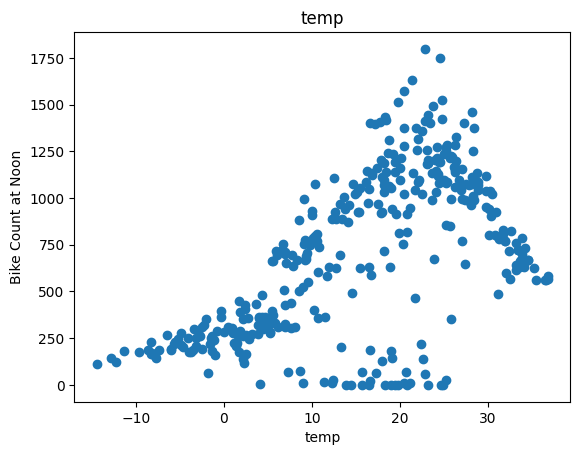

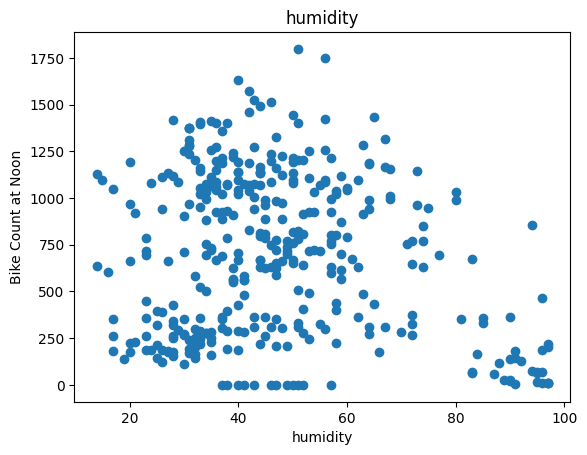

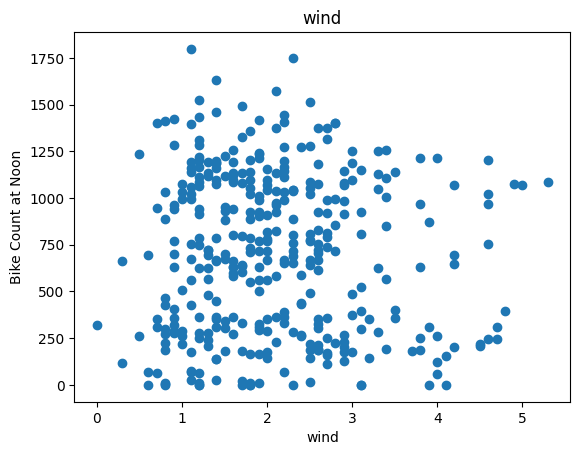

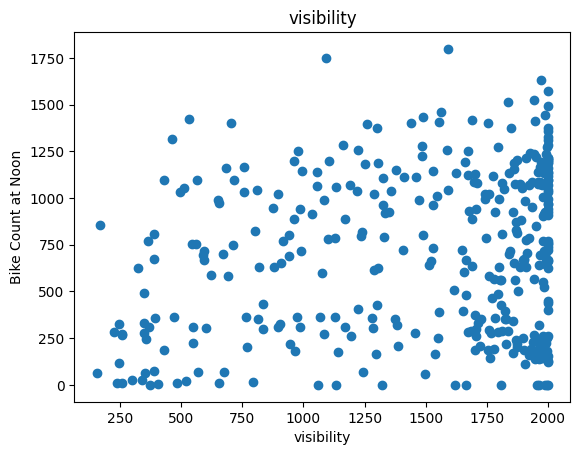

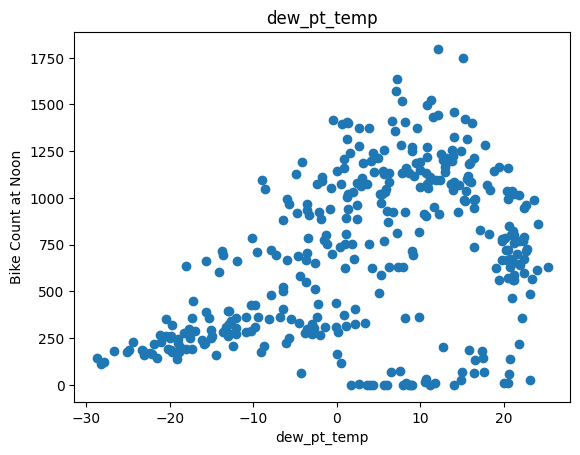

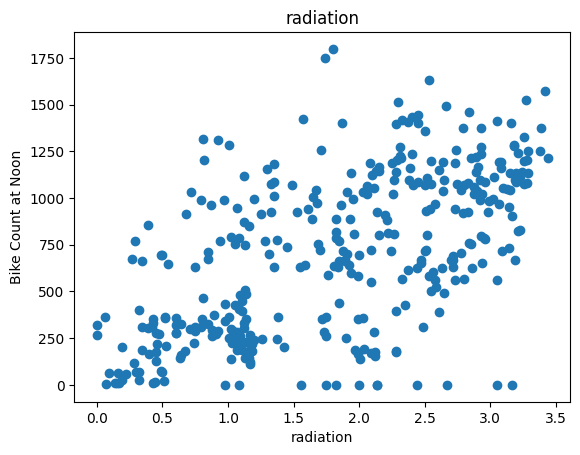

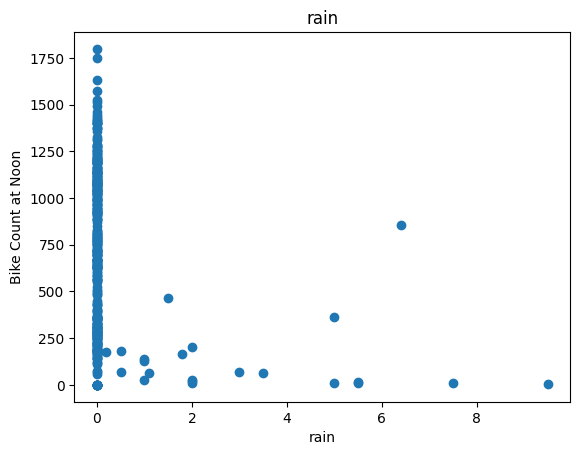

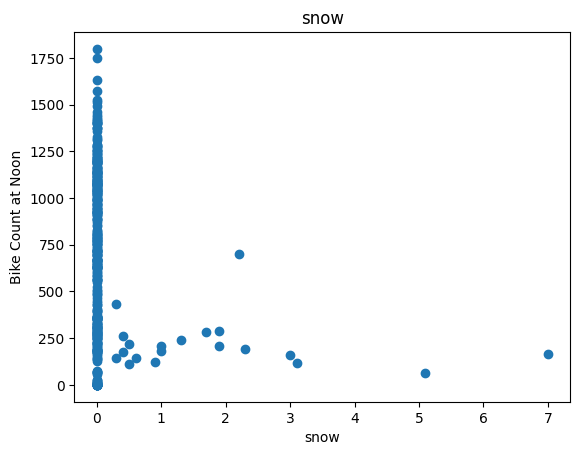

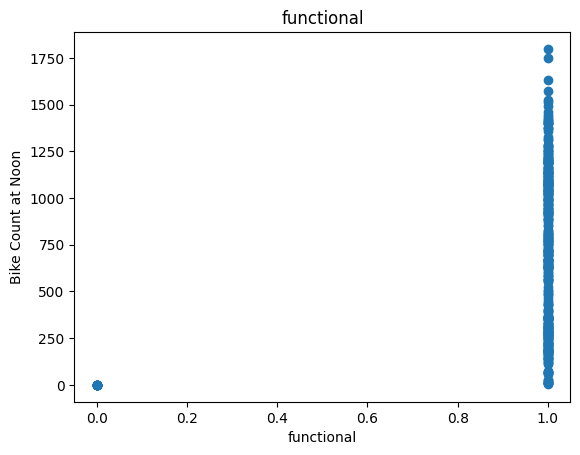

In [ ]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [ ]:
#vou me livrar de visibilidade, vento e funcionalidade
df = df.drop(["visibility", "wind", "functional"], axis = 1)

In [ ]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/Valid/Test Dataset

In [ ]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
#função para receber X e Y
def get_XY(dataframe, y_label, x_labels = None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].value
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values
  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y

In [ ]:
_, X_train_temp, y_train_temp = get_XY(train, "bike_count", x_labels=["temp"] )
_, X_val_temp, y_val_temp = get_XY(val, "bike_count", x_labels=["temp"] )
_, X_test_temp, y_test_temp = get_XY(test, "bike_count", x_labels=["temp"] )

In [ ]:
X_train_temp

array([[ -4.9],
       [  4. ],
       [ 36.6],
       [ 23.7],
       [ 32. ],
       [  6.9],
       [ 33.9],
       [ 24.9],
       [ 23.2],
       [ 21.9],
       [ 28.7],
       [ 20.5],
       [ 27. ],
       [ 16.7],
       [ 34.5],
       [  1.1],
       [ 36.8],
       [ 17.9],
       [  9.2],
       [ 19.2],
       [ 22.1],
       [ 13.3],
       [ 24.7],
       [ 16.6],
       [  8.5],
       [  6.9],
       [ -3.7],
       [  8.6],
       [  0.9],
       [ 18.2],
       [ 24.5],
       [ 13.8],
       [ 22.2],
       [ -2.9],
       [ 17.8],
       [ -0.3],
       [ 26.7],
       [ 18.2],
       [ 36.8],
       [ 18. ],
       [ -0.8],
       [ 18.4],
       [ 30.8],
       [  4.7],
       [ 20.5],
       [ 25.7],
       [ 25.2],
       [ 15.1],
       [  1. ],
       [ 15.7],
       [ 19.8],
       [ 22.9],
       [ 11.5],
       [ 12.3],
       [ -0.3],
       [  0. ],
       [ 25.2],
       [ 14.7],
       [ 26.3],
       [ -5.2],
       [ 31.1],
       [ 25.2],
       [

In [ ]:
temp_reg = LinearRegression()
#ajuste
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [ ]:
#imprimindo os coeficientes e a interceptação
print(temp_reg.coef_, temp_reg.intercept_)

[[20.50551201]] [376.68064264]


In [ ]:
#pontuação de r ao quadrado
temp_reg.score(X_test_temp, y_test_temp)

0.3671957709548638

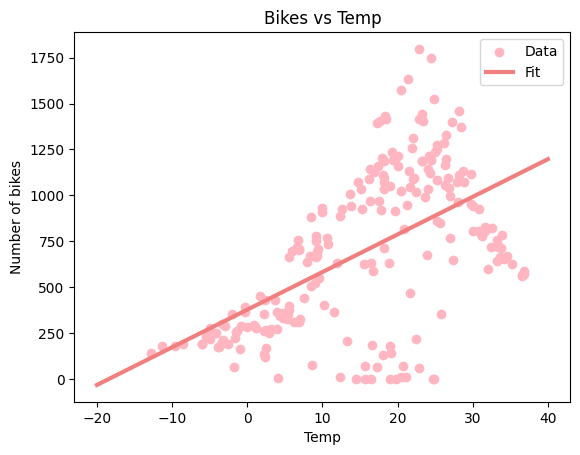

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="lightpink")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="lightcoral", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [ ]:
#Aqui eu fiz o mesmo passo a passo, mas agora usando a radiação
_, X_train_radiation, y_train_radiation = get_XY(train, "bike_count", x_labels=["radiation"] )
_, X_val_radiation, y_val_radiation = get_XY(val, "bike_count", x_labels=["radiation"] )
_, X_test_radiation, y_test_radiation = get_XY(test, "bike_count", x_labels=["radiation"] )

In [ ]:
radiation_reg = LinearRegression()
#ajuste
radiation_reg.fit(X_train_radiation, y_train_radiation)

LinearRegression()

In [ ]:
#pontuação de r ao quadrado
radiation_reg.score(X_test_radiation, y_test_radiation)

0.1950162741153364

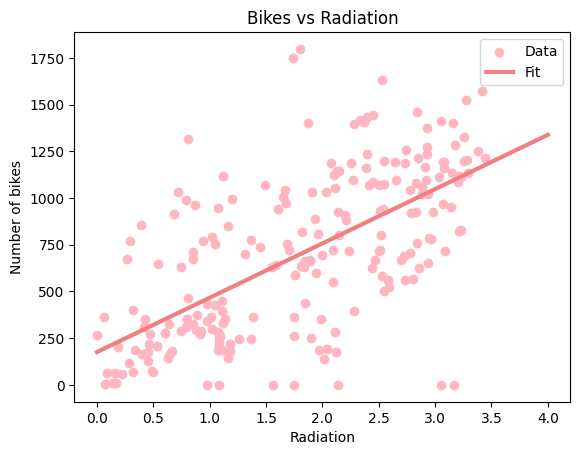

In [ ]:
plt.scatter(X_train_radiation, y_train_radiation, label="Data", color="lightpink")
x = tf.linspace(0, 4, 100)
plt.plot(x, radiation_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="lightcoral", linewidth=3)
plt.legend()
plt.title("Bikes vs Radiation")
plt.ylabel("Number of bikes")
plt.xlabel("Radiation")
plt.show()

# Multiple Linear Regression

In [ ]:
df.columns

Index(['bike_count', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [ ]:
_, X_train_all, y_train_all = get_XY(train, "bike_count", x_labels=df.columns[1:] )
_, X_val_all, y_val_all = get_XY(val, "bike_count", x_labels=df.columns[1:] )
_, X_test_all, y_test_all = get_XY(test, "bike_count", x_labels=df.columns[1:] )

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [ ]:
#melhorou em relação ao anterior, temperatura
all_reg.score(X_test_all, y_test_all)

0.44114509942022617

# Regression with Neural Net

In [ ]:
#plotagem da perda, mesma do notebook anterior
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
#se normalizarmos ajuda, e com o tensor flow vamos criar uma camada normalizadora
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [ ]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose = 0,
    epochs = 1000,
    validation_data = (X_val_temp, y_val_temp)
)

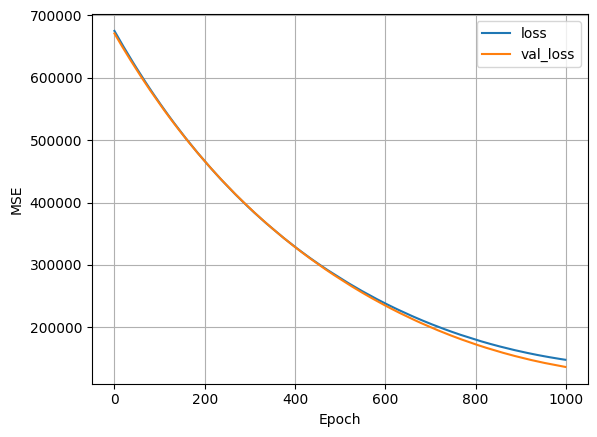

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 5ms/step


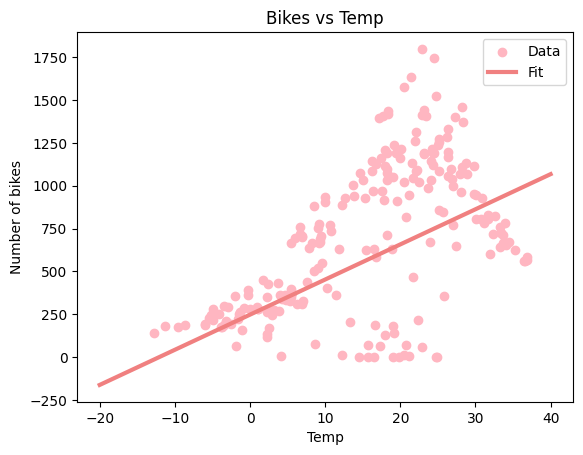

In [ ]:
#mesmo grafico, mudamos apenas para o de rede neural
plt.scatter(X_train_temp, y_train_temp, label="Data", color="lightpink")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="lightcoral", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

# Neural Net

In [ ]:
#vamos usar uma rede neural de verdade, e não apenas uma com um único nó, como foi feito anteriormente
#32 camadas densas, e vamos usar o Relu com função de ativação, e apneas uma resposta final
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'relu')
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_val_temp, y_val_temp),
    verbose = 0,
    epochs = 100
    )

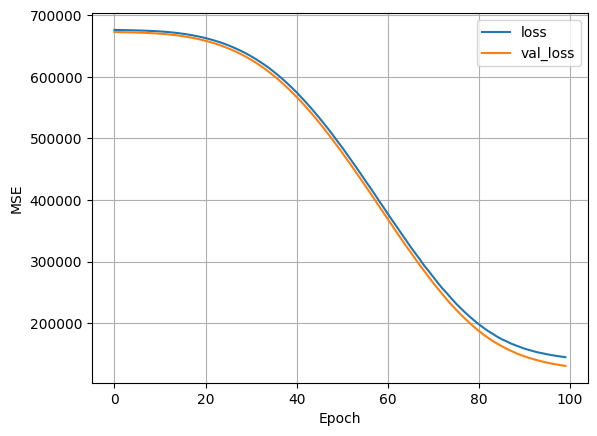

In [ ]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


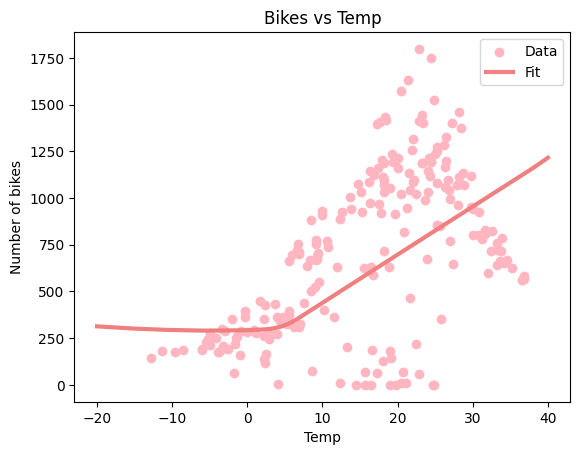

In [ ]:
#mesmo grafico, mudamos apenas para o de rede neural
plt.scatter(X_train_temp, y_train_temp, label="Data", color="lightpink")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="lightcoral", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [ ]:
#repetindo o mesmo exercicio com as múltiplas entradas
all_normalizer = tf.keras.layers.Normalization(input_shape = (6,), axis = -1)
all_normalizer.adapt(X_train_all)

In [ ]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

In [ ]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data = (X_val_all, y_val_all),
    verbose = 0,
    epochs = 100
    )

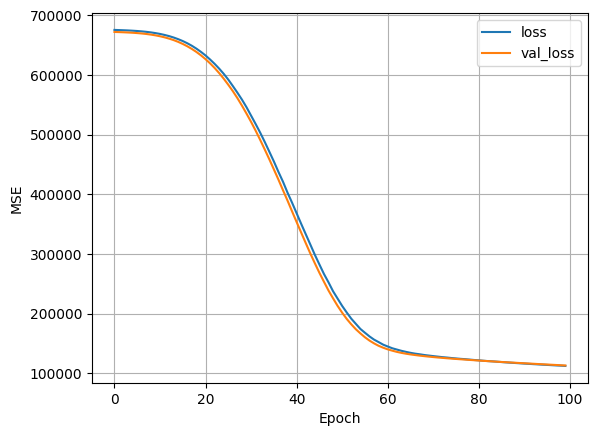

In [ ]:
plot_loss(history)

In [ ]:
#calculate the MSE(erro quadrático médio) for both linear regression and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 5ms/step


In [ ]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [ ]:
MSE(y_pred_lr, y_test_all)

99104.25221701863

In [ ]:
MSE(y_pred_nn, y_test_all)

122527.08656127457

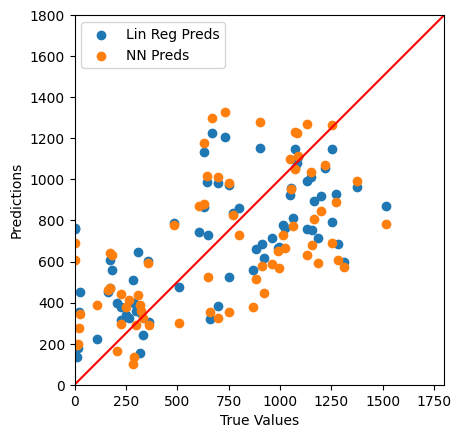

In [ ]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test_all, y_pred_lr, label = "Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label = "NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c = "red")

In [ ]:
#as vezes um regressor linear é mais apropriado ou uma rede neural é mais apropriada, e isso vem com
#o tempo de ver quem funciona melhor